In [2]:
# --- STEP 0: ENVIRONMENT FIX (Run this first!) ---
# This forces the environment to use compatible library versions.
# If you see an error, restart the kernel and run this again.
import sys
%pip install "numpy<2.0" pandas fastf1 matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# --- STEP 1: IMPORT LIBRARIES & SETUP PATHS ---
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Define File Paths (Relative to the 'notebooks' folder)
# We use '..' to go up one level to the project root
DATA_DIR = '../data'
DATA_PATH = os.path.join(DATA_DIR, 'clean_lap_data.csv')

# Ensure the data directory exists
os.makedirs(DATA_DIR, exist_ok=True)
print(f"📂 Data Directory: {os.path.abspath(DATA_DIR)}")

📂 Data Directory: d:\PROJECTS\f1-dynamic-strategy-optimization\data


In [4]:
# --- STEP 2: CONFIGURE CACHE ---
# FastF1 needs a folder to store downloaded data
# We'll try to put the cache in the backend folder to keep things tidy
cache_dir = '../backend/cache' 
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir) 
print(f"✅ Cache enabled at {cache_dir}")

✅ Cache enabled at ../backend/cache


In [5]:
# --- STEP 3: LOAD DATA ---
# Loading Bahrain 2024 (Season Opener)
# You can change this to any race (e.g., 'Monza', 'Silverstone')
year = 2024
gp = 'Bahrain'
session_type = 'R' # R = Race

print(f"Downloading {gp} {year} data...")
session = fastf1.get_session(year, gp, session_type)
session.load()
print(f"✅ Loaded {session.event['EventName']}")

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

✅ Loaded Bahrain Grand Prix


In [6]:
# --- STEP 4: DATA PROCESSING ---
# Pick a driver to analyze (Max Verstappen 'VER')
driver = 'VER'
laps = session.laps.pick_driver(driver)

# Filter out "slow" laps (Pit In, Pit Out, Safety Car)
# This gives us pure race pace data for the model
clean_laps = laps.pick_quicklaps().reset_index()

# Create the specific columns we need for Machine Learning
# We need numeric values, so we convert the 'LapTime' (TimeDelta) to Seconds (Float)
clean_laps['LapTimeSeconds'] = clean_laps['LapTime'].dt.total_seconds()

# Select only relevant columns
final_data = clean_laps[['LapNumber', 'TyreLife', 'LapTime', 'LapTimeSeconds', 'Compound', 'Stint']].copy()

print(f"\n--- Extracted Data for {driver} ---")
print(final_data.head())


--- Extracted Data for VER ---
   LapNumber  TyreLife                LapTime  LapTimeSeconds Compound  Stint
0        1.0       4.0 0 days 00:01:37.284000          97.284     SOFT    1.0
1        2.0       5.0 0 days 00:01:36.296000          96.296     SOFT    1.0
2        3.0       6.0 0 days 00:01:36.753000          96.753     SOFT    1.0
3        4.0       7.0 0 days 00:01:36.647000          96.647     SOFT    1.0
4        5.0       8.0 0 days 00:01:37.173000          97.173     SOFT    1.0


d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [7]:
# --- STEP 5: SAVE DATA (CRITICAL) ---
# This saves the clean data to the dedicated data folder.
final_data.to_csv(DATA_PATH, index=False)
print(f"\n✅ Data successfully saved to '{DATA_PATH}'")


✅ Data successfully saved to '../data\clean_lap_data.csv'


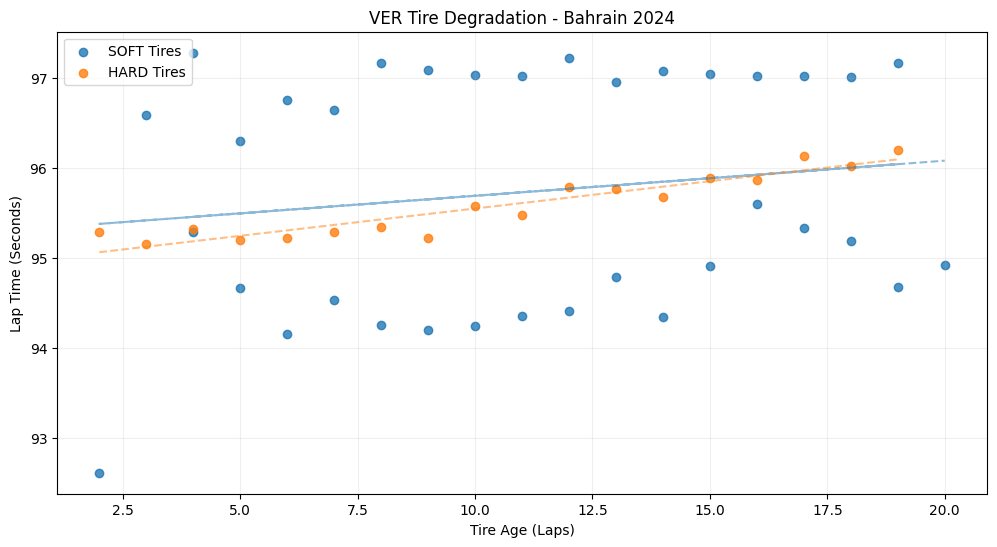

In [8]:
# --- STEP 6: VISUALIZATION ---
# Plot the data to verify it looks correct (Upward trend = Tire Degradation)
fastf1.plotting.setup_mpl()
fig, ax = plt.subplots(figsize=(12, 6))

for compound in final_data['Compound'].unique():
    subset = final_data[final_data['Compound'] == compound]
    ax.scatter(subset['TyreLife'], subset['LapTimeSeconds'], label=f"{compound} Tires", alpha=0.8)
    
    # Add a trendline to visually see the degradation
    if len(subset) > 1:
        z = np.polyfit(subset['TyreLife'], subset['LapTimeSeconds'], 1)
        p = np.poly1d(z)
        ax.plot(subset['TyreLife'], p(subset['TyreLife']), linestyle="--", alpha=0.5)

ax.set_xlabel("Tire Age (Laps)")
ax.set_ylabel("Lap Time (Seconds)")
ax.set_title(f"{driver} Tire Degradation - {gp} {year}")
ax.legend()
ax.grid(True, alpha=0.2)

plt.show()